# Your First RAG Application

In this notebook, we'll walk you through each of the components that are involved in a simple RAG application.

We won't be leveraging any fancy tools, just the OpenAI Python SDK, Numpy, and some classic Python.

> NOTE: This was done with Python 3.11.4.

> NOTE: There might be [compatibility issues](https://github.com/wandb/wandb/issues/7683) if you're on NVIDIA driver >552.44 As an interim solution - you can rollback your drivers to the 552.44.

## Table of Contents:

- Task 1: Imports and Utilities
- Task 2: Documents
- Task 3: Embeddings and Vectors
- Task 4: Prompts
- Task 5: Retrieval Augmented Generation
  - 🚧 Activity #1: Augment RAG

Let's look at a rather complicated looking visual representation of a basic RAG application.

<img src="https://i.imgur.com/vD8b016.png" />

## Task 1: Imports and Utility

We're just doing some imports and enabling `async` to work within the Jupyter environment here, nothing too crazy!

In [1]:
from aimakerspace.text_utils import TextFileLoader, CharacterTextSplitter
from aimakerspace.vectordatabase import VectorDatabase

import asyncio

In [2]:
import nest_asyncio
nest_asyncio.apply()

## Task 2: Documents

We'll be concerning ourselves with this part of the flow in the following section:

<img src="https://i.imgur.com/jTm9gjk.png" />

### Loading Source Documents

So, first things first, we need some documents to work with.

While we could work directly with the `.txt` files (or whatever file-types you wanted to extend this to) we can instead do some batch processing of those documents at the beginning in order to store them in a more machine compatible format.

In this case, we're going to parse our text file into a single document in memory.

Let's look at the relevant bits of the `TextFileLoader` class:

```python
def load_file(self):
        with open(self.path, "r", encoding=self.encoding) as f:
            self.documents.append(f.read())
```

We're simply loading the document using the built in `open` method, and storing that output in our `self.documents` list.


In [3]:
text_loader = TextFileLoader("data/PMarcaBlogs.txt")
documents = text_loader.load_documents()
len(documents)

1

In [4]:
print(documents[0][:100])


The Pmarca Blog Archives
(select posts from 2007-2009)
Marc Andreessen
copyright: Andreessen Horow


### Splitting Text Into Chunks

As we can see, there is one massive document.

We'll want to chunk the document into smaller parts so it's easier to pass the most relevant snippets to the LLM.

There is no fixed way to split/chunk documents - and you'll need to rely on some intuition as well as knowing your data *very* well in order to build the most robust system.

For this toy example, we'll just split blindly on length.

>There's an opportunity to clear up some terminology here, for this course we will be stick to the following:
>
>- "source documents" : The `.txt`, `.pdf`, `.html`, ..., files that make up the files and information we start with in its raw format
>- "document(s)" : single (or more) text object(s)
>- "corpus" : the combination of all of our documents

As you can imagine (though it's not specifically true in this toy example) the idea of splitting documents is to break them into managable sized chunks that retain the most relevant local context.

In [5]:
text_splitter = CharacterTextSplitter()
split_documents = text_splitter.split_texts(documents)
len(split_documents)

373

Let's take a look at some of the documents we've managed to split.

In [6]:
split_documents[0:1]

['\ufeff\nThe Pmarca Blog Archives\n(select posts from 2007-2009)\nMarc Andreessen\ncopyright: Andreessen Horowitz\ncover design: Jessica Hagy\nproduced using: Pressbooks\nContents\nTHE PMARCA GUIDE TO STARTUPS\nPart 1: Why not to do a startup 2\nPart 2: When the VCs say "no" 10\nPart 3: "But I don\'t know any VCs!" 18\nPart 4: The only thing that matters 25\nPart 5: The Moby Dick theory of big companies 33\nPart 6: How much funding is too little? Too much? 41\nPart 7: Why a startup\'s initial business plan doesn\'t\nmatter that much\n49\nTHE PMARCA GUIDE TO HIRING\nPart 8: Hiring, managing, promoting, and Dring\nexecutives\n54\nPart 9: How to hire a professional CEO 68\nHow to hire the best people you\'ve ever worked\nwith\n69\nTHE PMARCA GUIDE TO BIG COMPANIES\nPart 1: Turnaround! 82\nPart 2: Retaining great people 86\nTHE PMARCA GUIDE TO CAREER, PRODUCTIVITY,\nAND SOME OTHER THINGS\nIntroduction 97\nPart 1: Opportunity 99\nPart 2: Skills and education 107\nPart 3: Where to go and wh

## Task 3: Embeddings and Vectors

Next, we have to convert our corpus into a "machine readable" format as we explored in the Embedding Primer notebook.

Today, we're going to talk about the actual process of creating, and then storing, these embeddings, and how we can leverage that to intelligently add context to our queries.

### OpenAI API Key

In order to access OpenAI's APIs, we'll need to provide our OpenAI API Key!

You can work through the folder "OpenAI API Key Setup" for more information on this process if you don't already have an API Key!

In [7]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

### Vector Database

Let's set up our vector database to hold all our documents and their embeddings!

While this is all baked into 1 call - we can look at some of the code that powers this process to get a better understanding:

Let's look at our `VectorDatabase().__init__()`:

```python
def __init__(self, embedding_model: EmbeddingModel = None):
        self.vectors = defaultdict(np.array)
        self.embedding_model = embedding_model or EmbeddingModel()
```

As you can see - our vectors are merely stored as a dictionary of `np.array` objects.

Secondly, our `VectorDatabase()` has a default `EmbeddingModel()` which is a wrapper for OpenAI's `text-embedding-3-small` model.

> **Quick Info About `text-embedding-3-small`**:
> - It has a context window of **8191** tokens
> - It returns vectors with dimension **1536**

#### ❓Question #1:

The default embedding dimension of `text-embedding-3-small` is 1536, as noted above. 

1. Is there any way to modify this dimension?
2. What technique does OpenAI use to achieve this?

> NOTE: Check out this [API documentation](https://platform.openai.com/docs/api-reference/embeddings/create) for the answer to question #1, and [this documentation](https://platform.openai.com/docs/guides/embeddings/use-cases) for an answer to question #2!

My answers to the homework questions are:

📝 #### Answer 1.1. By default, the length of the embedding vector will be 1536 for text-embedding-3-small. It is optional and can be set. The Parameter is dimensions.

📝 #### Answer 1.2. They use embedding models to create text embeddings. 

To get an embedding, send your text string to the embeddings API endpoint along with the embedding model name (e.g. text-embedding-3-small). The response will contain an embedding (list of floating point numbers), which you can extract, save in a vector database, and use for many different use cases:

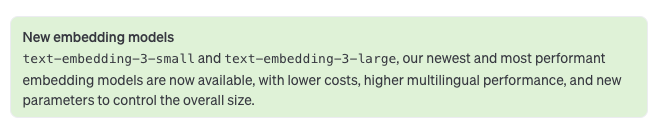

We can call the `async_get_embeddings` method of our `EmbeddingModel()` on a list of `str` and receive a list of `float` back!

```python
async def async_get_embeddings(self, list_of_text: List[str]) -> List[List[float]]:
        return await aget_embeddings(
            list_of_text=list_of_text, engine=self.embeddings_model_name
        )
```

We cast those to `np.array` when we build our `VectorDatabase()`:

```python
async def abuild_from_list(self, list_of_text: List[str]) -> "VectorDatabase":
        embeddings = await self.embedding_model.async_get_embeddings(list_of_text)
        for text, embedding in zip(list_of_text, embeddings):
            self.insert(text, np.array(embedding))
        return self
```

And that's all we need to do!

In [8]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

#### ❓Question #2:

What are the benefits of using an `async` approach to collecting our embeddings?

> NOTE: Determining the core difference between `async` and `sync` will be useful! If you get stuck - ask ChatGPT!

📝#### Answer 2.1. When the job or the function call is time-consuming and blocking in nature, 'Async' can unblock the dependency on the long and/or blocking function call. This not only improves the performance of the application by enabling parallel execution but also better experience for the user who can get a response faster.

So, to review what we've done so far in natural language:

1. We load source documents
2. We split those source documents into smaller chunks (documents)
3. We send each of those documents to the `text-embedding-3-small` OpenAI API endpoint
4. We store each of the text representations with the vector representations as keys/values in a dictionary

### Semantic Similarity

The next step is to be able to query our `VectorDatabase()` with a `str` and have it return to us vectors and text that is most relevant from our corpus.

We're going to use the following process to achieve this in our toy example:

1. We need to embed our query with the same `EmbeddingModel()` as we used to construct our `VectorDatabase()`
2. We loop through every vector in our `VectorDatabase()` and use a distance measure to compare how related they are
3. We return a list of the top `k` closest vectors, with their text representations

There's some very heavy optimization that can be done at each of these steps - but let's just focus on the basic pattern in this notebook.

> We are using [cosine similarity](https://www.engati.com/glossary/cosine-similarity) as a distance metric in this example - but there are many many distance metrics you could use - like [these](https://flavien-vidal.medium.com/similarity-distances-for-natural-language-processing-16f63cd5ba55)

> We are using a rather inefficient way of calculating relative distance between the query vector and all other vectors - there are more advanced approaches that are much more efficient, like [ANN](https://towardsdatascience.com/comprehensive-guide-to-approximate-nearest-neighbors-algorithms-8b94f057d6b6)

In [9]:
vector_db.search_by_text("What is the Michael Eisner Memorial Weak Executive Problem?", k=3)

[('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product manager who has a weak\nproduct management executive. The CEO who used to be in\nsales who has a weak sales executive. The CEO who used to be\nin marketing who has a weak marketing executive.\nI call this the “Michael Eisner Memorial Weak Executive Problem” — aaer the CEO of Disney who had previously been a brilliant TV network executive. When he bought ABC at Disney, it\npromptly fell to fourth place. His response? “If I had an extra\ntwo days a week, I could turn around ABC myself.” Well, guess\nwhat, he didn’t have an extra two days a week.\nA CEO — or a startup founder — oaen has a hard time letting\ngo of the function that brought him to the party. The result: you\nhire someone weak into the executive role for that function so\nthat you can continue to b

## Task 4: Prompts

In the following section, we'll be looking at the role of prompts - and how they help us to guide our application in the right direction.

In this notebook, we're going to rely on the idea of "zero-shot in-context learning".

This is a lot of words to say: "We will ask it to perform our desired task in the prompt, and provide no examples."

### XYZRolePrompt

Before we do that, let's stop and think a bit about how OpenAI's chat models work.

We know they have roles - as is indicated in the following API [documentation](https://platform.openai.com/docs/api-reference/chat/create#chat/create-messages)

There are three roles, and they function as follows (taken directly from [OpenAI](https://platform.openai.com/docs/guides/gpt/chat-completions-api)):

- `{"role" : "system"}` : The system message helps set the behavior of the assistant. For example, you can modify the personality of the assistant or provide specific instructions about how it should behave throughout the conversation. However note that the system message is optional and the model’s behavior without a system message is likely to be similar to using a generic message such as "You are a helpful assistant."
- `{"role" : "user"}` : The user messages provide requests or comments for the assistant to respond to.
- `{"role" : "assistant"}` : Assistant messages store previous assistant responses, but can also be written by you to give examples of desired behavior.

The main idea is this:

1. You start with a system message that outlines how the LLM should respond, what kind of behaviours you can expect from it, and more
2. Then, you can provide a few examples in the form of "assistant"/"user" pairs
3. Then, you prompt the model with the true "user" message.

In this example, we'll be forgoing the 2nd step for simplicities sake.

#### Utility Functions

You'll notice that we're using some utility functions from the `aimakerspace` module - let's take a peek at these and see what they're doing!

##### XYZRolePrompt

Here we have our `system`, `user`, and `assistant` role prompts.

Let's take a peek at what they look like:

```python
class BasePrompt:
    def __init__(self, prompt):
        """
        Initializes the BasePrompt object with a prompt template.

        :param prompt: A string that can contain placeholders within curly braces
        """
        self.prompt = prompt
        self._pattern = re.compile(r"\{([^}]+)\}")

    def format_prompt(self, **kwargs):
        """
        Formats the prompt string using the keyword arguments provided.

        :param kwargs: The values to substitute into the prompt string
        :return: The formatted prompt string
        """
        matches = self._pattern.findall(self.prompt)
        return self.prompt.format(**{match: kwargs.get(match, "") for match in matches})

    def get_input_variables(self):
        """
        Gets the list of input variable names from the prompt string.

        :return: List of input variable names
        """
        return self._pattern.findall(self.prompt)
```

Then we have our `RolePrompt` which laser focuses us on the role pattern found in most API endpoints for LLMs.

```python
class RolePrompt(BasePrompt):
    def __init__(self, prompt, role: str):
        """
        Initializes the RolePrompt object with a prompt template and a role.

        :param prompt: A string that can contain placeholders within curly braces
        :param role: The role for the message ('system', 'user', or 'assistant')
        """
        super().__init__(prompt)
        self.role = role

    def create_message(self, **kwargs):
        """
        Creates a message dictionary with a role and a formatted message.

        :param kwargs: The values to substitute into the prompt string
        :return: Dictionary containing the role and the formatted message
        """
        return {"role": self.role, "content": self.format_prompt(**kwargs)}
```

We'll look at how the `SystemRolePrompt` is constructed to get a better idea of how that extension works:

```python
class SystemRolePrompt(RolePrompt):
    def __init__(self, prompt: str):
        super().__init__(prompt, "system")
```

That pattern is repeated for our `UserRolePrompt` and our `AssistantRolePrompt` as well.

##### ChatOpenAI

Next we have our model, which is converted to a format analagous to libraries like LangChain and LlamaIndex.

Let's take a peek at how that is constructed:

```python
class ChatOpenAI:
    def __init__(self, model_name: str = "gpt-4o-mini"):
        self.model_name = model_name
        self.openai_api_key = os.getenv("OPENAI_API_KEY")
        if self.openai_api_key is None:
            raise ValueError("OPENAI_API_KEY is not set")

    def run(self, messages, text_only: bool = True):
        if not isinstance(messages, list):
            raise ValueError("messages must be a list")

        openai.api_key = self.openai_api_key
        response = openai.ChatCompletion.create(
            model=self.model_name, messages=messages
        )

        if text_only:
            return response.choices[0].message.content

        return response
```

#### ❓ Question #3:

When calling the OpenAI API - are there any ways we can achieve more reproducible outputs?

> NOTE: Check out [this section](https://platform.openai.com/docs/guides/text-generation/) of the OpenAI documentation for the answer!

📝 #### Answer 3.1. Yes, we can achieve more reproducible outputs by setting the seed and temperature.

temperature
number or null

Optional
Defaults to 1
What sampling temperature to use, between 0 and 2. Higher values like 0.8 will make the output more random, while lower values like 0.2 will make it more focused and deterministic. We generally recommend altering this or top_p but not both.

seed
integer or null

Optional
This feature is in Beta. If specified, our system will make a best effort to sample deterministically, such that repeated requests with the same seed and parameters should return the same result. Determinism is not guaranteed, and you should refer to the system_fingerprint response parameter to monitor changes in the backend.

### Creating and Prompting OpenAI's `gpt-4o-mini`!

Let's tie all these together and use it to prompt `gpt-4o-mini`!

In [10]:
from aimakerspace.openai_utils.prompts import (
    UserRolePrompt,
    SystemRolePrompt,
    AssistantRolePrompt,
)

from aimakerspace.openai_utils.chatmodel import ChatOpenAI

chat_openai = ChatOpenAI()
user_prompt_template = "{content}"
user_role_prompt = UserRolePrompt(user_prompt_template)
system_prompt_template = (
    "You are an expert in {expertise}, you always answer in a kind way."
)
system_role_prompt = SystemRolePrompt(system_prompt_template)

messages = [
    system_role_prompt.create_message(expertise="Python"),
    user_role_prompt.create_message(
        content="What is the best way to write a loop?"
    ),
]

response = chat_openai.run(messages)

In [11]:
print(response)

The best way to write a loop in Python depends on the specific task you are trying to accomplish. However, I can share some general tips and examples for different types of loops that are commonly used in Python.

### 1. Using a `for` loop:
`for` loops are great for iterating over items in a sequence (like lists, tuples, strings, etc.).

```python
# Example: Iterating through a list
fruits = ['apple', 'banana', 'cherry']
for fruit in fruits:
    print(fruit)
```

### 2. Using a `while` loop:
`while` loops are useful when you want to continue looping until a certain condition is met.

```python
# Example: Simple countdown
count = 5
while count > 0:
    print(count)
    count -= 1
```

### 3. Using List Comprehensions:
For creating lists, list comprehensions offer a concise way to create lists based on existing lists.

```python
# Example: Create a list of squares
squares = [x ** 2 for x in range(10)]
print(squares)
```

### 4. Using `enumerate()` in a loop:
If you need both the index an

## Task 5: Retrieval Augmented Generation

Now we can create a RAG prompt - which will help our system behave in a way that makes sense!

There is much you could do here, many tweaks and improvements to be made!

In [12]:
RAG_PROMPT_TEMPLATE = """ \
Use the provided context to answer the user's query.

You may not answer the user's query unless there is specific context in the following text.

If you do not know the answer, or cannot answer, please respond with "I don't know" and why you don't know.
"""

rag_prompt = SystemRolePrompt(RAG_PROMPT_TEMPLATE)

USER_PROMPT_TEMPLATE = """ \
Context:
{context}

User Query:
{user_query}
"""


user_prompt = UserRolePrompt(USER_PROMPT_TEMPLATE)

class RetrievalAugmentedQAPipeline:
    def __init__(self, llm: ChatOpenAI(), vector_db_retriever: VectorDatabase) -> None:
        self.llm = llm
        self.vector_db_retriever = vector_db_retriever

    def run_pipeline(self, user_query: str) -> str:
        context_list = self.vector_db_retriever.search_by_text(user_query, k=3, return_as_text=True)

        context_prompt = ""
        for context in context_list:
            context_prompt += context[0] + "\n"

        formatted_system_prompt = rag_prompt.create_message()

        formatted_user_prompt = user_prompt.create_message(user_query=user_query, context=context_prompt)

        return {"response" : self.llm.run([formatted_system_prompt, formatted_user_prompt]), "context" : context_list}

#### ❓ Question #4:

What prompting strategies could you use to make the LLM have a more thoughtful, detailed response?

What is that strategy called?

> NOTE: You can look through the Week 1 Day 1 "Prompting OpenAI Like A Developer" material for an answer to this question!

📝 #### Answer 4.1. Implement Chaint of Thought prompting strategy.

In the prompt, tell the LLM to think step by step. You can also tell LLM to detail the response.

Another strategy is to do few shot prompting, give examples of the desired output.

In [13]:
retrieval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai
)

In [14]:
retrieval_augmented_qa_pipeline.run_pipeline("What is the 'Michael Eisner Memorial Weak Executive Problem'?")

{'response': "The 'Michael Eisner Memorial Weak Executive Problem' refers to a phenomenon where a CEO, who has a strong background in a particular area, hires a weak executive to manage that same area. This often occurs because the CEO finds it difficult to relinquish control over their area of expertise and thus chooses a subordinate who is less competent, allowing the CEO to maintain influence. The term is named after Michael Eisner, the former CEO of Disney, who, despite his experience in television, faced challenges when he acquired ABC and saw it decline, suggesting that he overestimated his ability to manage that division effectively.",
 'context': [('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product manager who has a weak\nproduct management executive. The CEO who used to be in\nsales who has a weak sale

### 🏗️ Activity #1:

Enhance your RAG application in some way! 

Suggestions are: 

- Allow it to work with PDF files
- Implement a new distance metric
- Add metadata support to the vector database

While these are suggestions, you should feel free to make whatever augmentations you desire! 

> NOTE: These additions might require you to work within the `aimakerspace` library - that's expected!

I change text_utils.py to load pdf files and split them into chunks.

In [15]:
text_loader = TextFileLoader("data/2024trends.pdf")
documents = text_loader.load_documents()
len(documents)

1

I loaded a sample pdf file and split it into chunks.

In [16]:
print(documents[0][:100])

AI Is Disrupting the Legal Industry
| 1
Introduction
Lawyers are wasting time—and losing endless Art


I am adding the two files to the vector database.

In [17]:
text_splitter = CharacterTextSplitter()
split_documents += text_splitter.split_texts(documents)
len(split_documents)

486

In [18]:
split_documents[10:50]

[' you do get a “yes”, half the time you’ll get a call two\ndays later and it’ll turn out the answer has morphed into “no”.\nBetter start working on your fake smile.\nFourth, hiring is a huge pain in the ass.\nYou will be amazed how many windowshoppers you’ll deal with.\nA lot of people think they want to be part of a startup, but when\nthe time comes to leave their cushy job at HP or Apple, they\nYinch — and stay.\nGoing through the recruiting process and being seduced by a\nstartup is heady stuW for your typical engineer or midlevel manager at a big company — you get to participate vicariously in the\nthrill of a startup without actually having to join or do any of the\nhard work.\nAs a founder of a startup trying to hire your team, you’ll run into\nthis again and again.\nWhen Jim Clark decided to start a new company in 1994, I was\none of about a dozen people at various Silicon Valley companies\nhe was talking to about joining him in what became Netscape.\nI was the only one who wen

Building the vector database.

In [19]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

Testing the vector database with the legal trends pdf file.

In [20]:
vector_db.search_by_text("What are the legal trends in 2024?", k=3)

[('remendous potential for law firms—if\nthey’re prepared to adopt it. But how do law firms\nfeel about AI at this time?\nWhen we last researched AI in 2023, 19% of law firms were\nusing AI in their practice.\nOver the last year, that number has skyrocketed: a whopping\n79% of surveyed legal professionals are now using AI in some\ncapacity in their practice, while 25% have adopted AI widely\nor universally.\nSurprisingly, lawyers are adopting AI at a faster rate than in other industries.\nA recent survey by McKinsey & Company that looked at the full spectrum of\nindustries and professions found that 72% of organizations have adopted AI\nin at least one business function. This average falls below what we’re seeing\namong law firms, which means we may be seeing a historical first wherein\nthe legal profession is leading the way in the adoption of new technology.\nAI adoption is no longer limited to legal trailblazers—it’s the new normal in law\nfirms. Regardless of where firms stand on A

Testing the retrieval augmented generation pipeline with the legal trends pdf file.

In [21]:

retrieval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai
)

retrieval_augmented_qa_pipeline.run_pipeline("Can the legal profession be automated?")

{'response': "Yes, the legal profession can be automated to a significant extent. A study from Goldman Sachs indicated that 44% of work tasks performed in the legal industry could potentially be automated by AI. While many information-heavy tasks, such as documenting, recording, and analyzing data, are particularly ripe for automation, it's important to note that certain tasks requiring a human touch—like high-level legal work and client advocacy—are less amenable to automation. Therefore, while AI can enhance efficiency and productivity within the legal profession, it also necessitates a mindset shift in how firms operate and deliver services.",
 'context': [('ly exposed to automation by AI.\nimpact. Legal professionals—from lawyers to paralegals and\nTo that end, automation can offer firms the space to focus on the tasks that\nadministrative assistants—are devoting a significant portion of\nrequire a human touch—like high-level legal work, advocacy, and fostering\ntheir time to tasks

Implemented the jaccard and cosine similarity distance metrics. 


In [22]:
from aimakerspace.vectordatabase import jaccard_similarity
from aimakerspace.vectordatabase import cosine_similarity

vector_db.search_by_text("What is the 'Michael Eisner Memorial Weak Executive Problem'?", k=3, distance_measure=jaccard_similarity)



[('\ufeff\nThe Pmarca Blog Archives\n(select posts from 2007-2009)\nMarc Andreessen\ncopyright: Andreessen Horowitz\ncover design: Jessica Hagy\nproduced using: Pressbooks\nContents\nTHE PMARCA GUIDE TO STARTUPS\nPart 1: Why not to do a startup 2\nPart 2: When the VCs say "no" 10\nPart 3: "But I don\'t know any VCs!" 18\nPart 4: The only thing that matters 25\nPart 5: The Moby Dick theory of big companies 33\nPart 6: How much funding is too little? Too much? 41\nPart 7: Why a startup\'s initial business plan doesn\'t\nmatter that much\n49\nTHE PMARCA GUIDE TO HIRING\nPart 8: Hiring, managing, promoting, and Dring\nexecutives\n54\nPart 9: How to hire a professional CEO 68\nHow to hire the best people you\'ve ever worked\nwith\n69\nTHE PMARCA GUIDE TO BIG COMPANIES\nPart 1: Turnaround! 82\nPart 2: Retaining great people 86\nTHE PMARCA GUIDE TO CAREER, PRODUCTIVITY,\nAND SOME OTHER THINGS\nIntroduction 97\nPart 1: Opportunity 99\nPart 2: Skills and education 107\nPart 3: Where to go and w

Testing the results from both distance metrics.

In [23]:
vector_db.search_by_text("What is the 'Michael Eisner Memorial Weak Executive Problem'?", k=3, distance_measure=cosine_similarity)

[('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product manager who has a weak\nproduct management executive. The CEO who used to be in\nsales who has a weak sales executive. The CEO who used to be\nin marketing who has a weak marketing executive.\nI call this the “Michael Eisner Memorial Weak Executive Problem” — aaer the CEO of Disney who had previously been a brilliant TV network executive. When he bought ABC at Disney, it\npromptly fell to fourth place. His response? “If I had an extra\ntwo days a week, I could turn around ABC myself.” Well, guess\nwhat, he didn’t have an extra two days a week.\nA CEO — or a startup founder — oaen has a hard time letting\ngo of the function that brought him to the party. The result: you\nhire someone weak into the executive role for that function so\nthat you can continue to b

In [24]:
# Load documents with metadata
text_loader = TextFileLoader("data/PMarcaBlogs.txt")
documents = text_loader.load_documents()
metadata_list = text_loader.metadata

# Split documents and include metadata
text_splitter = CharacterTextSplitter()
split_documents = text_splitter.split_texts_with_metadata(documents, metadata_list)

# Example of accessing a chunk with its metadata
first_chunk = split_documents[1]
print(f"Text: {first_chunk['text'][:500]}...")
print(f"Metadata: {first_chunk['metadata']}")

Text: RCA GUIDE TO CAREER, PRODUCTIVITY,
AND SOME OTHER THINGS
Introduction 97
Part 1: Opportunity 99
Part 2: Skills and education 107
Part 3: Where to go and why 120
The Pmarca Guide to Personal Productivity 127
PSYCHOLOGY AND ENTREPRENEURSHIP
The Psychology of Entrepreneurial Misjudgment:
Biases 1-6
142
Age and the Entrepreneur: Some data 154
Luck and the entrepreneur: The four kinds of luck 162
Serial Entrepreneurs 168
THE BACK PAGES
Top 10 science Dction novelists of the '00s ... so far
(June 2007...
Metadata: {'source': 'data/PMarcaBlogs.txt', 'file_type': 'txt', 'created_date': '2025-01-19T12:28:40.707860', 'modified_date': '2025-01-16T19:31:08.153237', 'file_size': 302838, 'total_chars': 297904, 'chunk_index': 1, 'chunk_start': 800, 'chunk_end': 1800, 'chunk_size': 1000}


In [25]:
vector_db = VectorDatabase()
vector_db = asyncio.run(vector_db.abuild_from_list(split_documents))

I expanded the vector database to include metadata.

In [26]:
vector_db.search_by_text("What is the 'Michael Eisner Memorial Weak Executive Problem'?", k=3)

[('data/PMarcaBlogs.txt_115',
  np.float64(0.6582125113300628),
  {'source': 'data/PMarcaBlogs.txt',
   'file_type': 'txt',
   'created_date': '2025-01-19T12:28:40.707860',
   'modified_date': '2025-01-16T19:31:08.153237',
   'file_size': 302838,
   'total_chars': 297904,
   'chunk_index': 115,
   'chunk_start': 92000,
   'chunk_end': 93000,
   'chunk_size': 1000}),
 ('data/PMarcaBlogs.txt_133',
  np.float64(0.5088372362539734),
  {'source': 'data/PMarcaBlogs.txt',
   'file_type': 'txt',
   'created_date': '2025-01-19T12:28:40.707860',
   'modified_date': '2025-01-16T19:31:08.153237',
   'file_size': 302838,
   'total_chars': 297904,
   'chunk_index': 133,
   'chunk_start': 106400,
   'chunk_end': 107400,
   'chunk_size': 1000}),
 ('data/PMarcaBlogs.txt_132',
  np.float64(0.47903669405979216),
  {'source': 'data/PMarcaBlogs.txt',
   'file_type': 'txt',
   'created_date': '2025-01-19T12:28:40.707860',
   'modified_date': '2025-01-16T19:31:08.153237',
   'file_size': 302838,
   'total_ch

Run the search with a combined text and metadata.

In [27]:
eval_augmented_qa_pipeline = RetrievalAugmentedQAPipeline(
    vector_db_retriever=vector_db,
    llm=chat_openai
)

retrieval_augmented_qa_pipeline.run_pipeline("What is the 'Michael Eisner Memorial Weak Executive Problem'?")

{'response': "The 'Michael Eisner Memorial Weak Executive Problem' refers to a situation where a CEO or startup founder, who has expertise in a particular function, hires a weak executive to manage that same function. This often occurs because they want to maintain control over the area they are familiar with, allowing them to continue to be the primary decision-maker in that domain. The term is named after Michael Eisner, the former CEO of Disney, who faced challenges when he acquired ABC and struggled to revitalize it, highlighting the difficulties of letting go of control and the potential negative impact of hiring underqualified executives in areas where the CEO has prior experience.",
 'context': [('ordingly.\nSeventh, when hiring the executive to run your former specialty, be\ncareful you don’t hire someone weak on purpose.\nThis sounds silly, but you wouldn’t believe how oaen it happens.\nThe CEO who used to be a product manager who has a weak\nproduct management executive. The 

Here's my explanaton of my RAG process.

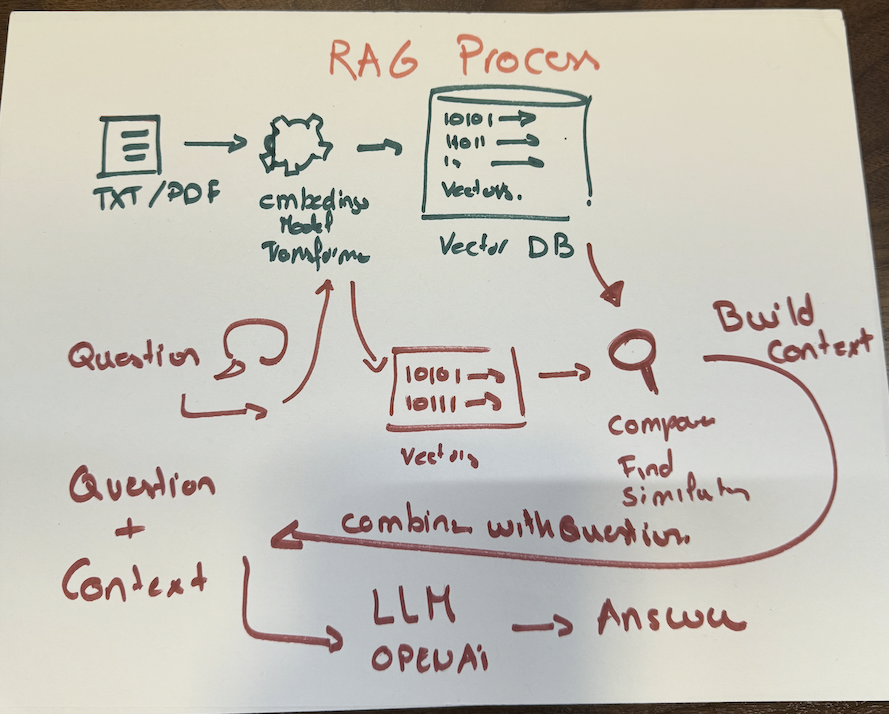